In this notebook we simulate future stock prices, risk-free rates, 3 year bonds and sharpe ratios from 31 october 2014 to 31 october 2033. We assume that the voatility follows stockastic process (Heston Model). We assume that other 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Market Simulation Code

$
\begin{cases}
r_{t+dt} = r_t + \kappa_r (\bar{lt_r} - r_t) dt + \sigma_r \sqrt{dt} Z_t^r\\
SR_{t+dt} = SR_t + \kappa_sr (\bar{lt_sr} - SR_t) dt + \sigma_SR \sqrt{dt} Z_t^SR\\
V_{t+dt} = V_t + \kappa_v (lt_V - V_t) dt + \sigma_V \sqrt{V_t} \sqrt{dt} Z_t^V\\
S_{t+dt} = S_t \times \exp \left( \left( r + \bar{\lambda_0} \sigma_t - \frac{1}{2} \sigma_t^2 \right) dt + \sigma_t \sqrt{dt} Z_t^S \right) \\
\end{cases}
$

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

class MarketSimulator:
    def __init__(
        self, 
        # Basic notations
        T,        # Total time in years for the simulation
        N,        # Number of discrete time steps; e.g., 252 for "trading days" in a year
        M,        # Number of simulation paths (scenarios)
        seed=123, # Random seed for reproducibility
        
        # Initial conditions
        S0=1,         # Initial stock price
        r0=0.15 / 100,      # Initial short rate
        sr0=0.4,      # Initial Sharpe ratio
        v0=(0.2138)**2, # Initial variance (square of initial volatility)
        
        # Short-rate (Vasicek) model parameters
        lt_r=0.0306,    # Long-term mean (b in Vasicek) to which r reverts
        kappa_r=0.13,   # Mean-reversion speed for short rate
        sigma_r=0.98/100, # Volatility (std dev) of short rate’s diffusion
        lambda_r=-53/100/100, # Market price of risk associated with interest rate movements
        
        # Sharpe-ratio (Ornstein–Uhlenbeck type) model parameters
        lt_sr=0.4,     # Long-term mean Sharpe ratio
        kappa_sr=0.35, # Mean-reversion speed for Sharpe ratio
        sigma_sr=0.2322, # Volatility (std dev) of Sharpe ratio process
        
        # Variance (Heston-like) model parameters
        kappa_variance=5.07,  # Mean-reversion speed of variance process
        lt_variance=(0.2138)**2, # Long-term mean of variance process
        sigma_variance=0.48,  # Vol of vol (volatility of variance process)
        
        # Correlations for covariance matrix
        # (Z is 4D, representing Brownian increments for: stock, variance, Sharpe ratio, short rate)
        rho_stock_volatility=-0.767, # Corr( dW_stock, dW_vol ) 
        rho_stock_sr=-0.2,           # Corr( dW_stock, dW_sr   )
        rho_volatility_sr=+0.767,    # Corr( dW_vol,   dW_sr   )

        # Constant maturity bond index set up
        tau = 3, # Time to maturity in years of the bond index (default = 3 years)
        B0 = 1   # Initial price of the bond index
    ):
        """Initializes the Market Simulator with all parameters."""
        
        # Simulation settings
        self.T, self.N, self.M, self.seed = T, N, M, seed  # Total time horizon, number of time steps, number of paths, random seed
        
        # Initial values
        self.S0, self.r0, self.sr0, self.v0 = S0, r0, sr0, v0  # Initial values for stock price, short rate, Sharpe ratio, and variance
        
        # Short-rate (Vasicek) model parameters
        self.lt_r, self.kappa_r, self.sigma_r, self.lambda_r = lt_r, kappa_r, sigma_r, lambda_r  # Long-term mean, mean reversion speed, volatility, and market price of risk
        
        # Sharpe-ratio (Ornstein–Uhlenbeck type) model parameters
        self.lt_sr, self.kappa_sr, self.sigma_sr = lt_sr, kappa_sr, sigma_sr  # Long-term mean, mean reversion speed, and volatility of Sharpe ratio
        
        # Variance (Heston-like) model parameters
        self.kappa_variance, self.lt_variance, self.sigma_variance = kappa_variance, lt_variance, sigma_variance  # Mean reversion speed, long-term mean, and vol of vol
        
        # Correlations for covariance matrix
        self.rho_stock_volatility, self.rho_stock_sr, self.rho_volatility_sr = rho_stock_volatility, rho_stock_sr, rho_volatility_sr  # Correlation among Brownian motions
        
        # Time step size in years
        self.dt = T / N  # Compute dt from total time and number of steps
        
        # Set up risk-neutral under Q measure long-term short rate
        self.lt_r_q = lt_r + sigma_r * lambda_r / kappa_r  # Adjusted long-term mean for risk-neutral valuation

        # generate the market paths
        self.generate_paths()

        # set up constant maturity bond index
        self.tau = tau 
        self.B0 = B0
        
        zero_coupon_bond_prices_for_constant_maturity_bond_index = self.vasicek_zcb_price(self.r_p, self.tau)
        
        # find price of constant maturity bond index
        self.B_p = self.deduce_constant_maturity_bond_index(zero_coupon_bond_prices_for_constant_maturity_bond_index)

        # set the retirement bond price to nothing. To initialize it run "self.calculate_perfect_retirement_bond(client)"
        # where client comes from 'RetirementClient' class
        self.retirement_bond_p = pd.DataFrame(index = self.r_p.index)
        
    def generate_paths(self):
        """Simulates multiple paths of stock price, variance, Sharpe ratio, and short rate."""
        np.random.seed(self.seed)  # Set random seed for reproducibility
        
        # Mean (0-vector) and covariance matrix for Brownian increments
        mu = np.array([0, 0, 0, 0])  # Zero mean for Brownian motion
        cov = np.array([
            [1, self.rho_stock_volatility, self.rho_stock_sr, 0],  # Correlation matrix for Brownian motions
            [self.rho_stock_volatility, 1, self.rho_volatility_sr, 0],
            [self.rho_stock_sr, self.rho_volatility_sr, 1, 0],
            [0, 0, 0, 1]  # Independent short rate process
        ])
        
        # Initialize paths
        S = np.full((self.N+1, self.M), self.S0)  # Stock price paths
        v = np.full((self.N+1, self.M), self.v0)  # Variance paths
        sr = np.full((self.N+1, self.M), self.sr0)  # Sharpe ratio paths
        r = np.full((self.N+1, self.M), self.r0)  # Short rate paths
        
        # Generate correlated Brownian increments
        Z = np.random.multivariate_normal(mu, cov, size=(self.N, self.M))
        
        # Main simulation loop
        for i in range(1, self.N+1):
            # Stock price evolution using exponential Euler scheme
            S[i] = S[i-1] * np.exp((r[i-1] + sr[i-1] * np.sqrt(v[i-1]) - 0.5 * v[i-1]) * self.dt + np.sqrt(v[i-1] * self.dt) * Z[i-1,:,0])
            
            # Variance follows a mean-reverting Heston-like process
            v[i] = np.maximum(v[i-1] + self.kappa_variance * (self.lt_variance - v[i-1]) * self.dt + self.sigma_variance * np.sqrt(v[i-1]) * np.sqrt(self.dt) * Z[i-1,:,1], 0)
            
            # Sharpe ratio follows an Ornstein–Uhlenbeck process
            sr[i] = sr[i-1] + self.kappa_sr * (self.lt_sr - sr[i-1]) * self.dt + self.sigma_sr * np.sqrt(self.dt) * Z[i-1,:,2]
            
            # Short rate follows a Vasicek model under the risk-neutral measure
            r[i] = r[i-1] + self.kappa_r * (self.lt_r_q - r[i-1]) * self.dt + self.sigma_r * np.sqrt(self.dt) * Z[i-1,:,3]
        
        # Convert outputs to DataFrame with time index

        self.S_p = pd.DataFrame(S, index=np.linspace(0, self.T, len(S)))
        self.v_p = pd.DataFrame(v, index=np.linspace(0, self.T, len(S)))
        self.sr_p = pd.DataFrame(sr, index=np.linspace(0, self.T, len(S)))
        self.r_p = pd.DataFrame(r, index=np.linspace(0, self.T, len(S)))

    def vasicek_zcb_price(self, r_t, tau):
        """
        Computes the price P(t, t+tau) of a zero-coupon bond under the Vasicek model.
    
        Parameters:
        - r_t: Short rate at time t
        - tau: Time to maturity in years (default = 3 years)
    
        Returns:
        - Price of the zero-coupon bond P(t, t+tau)
        """
        # Compute B(t, T) factor in Vasicek model
        B = (1.0 - np.exp(-self.kappa_r * tau)) / self.kappa_r
    
        # Compute A(t, T) factor in Vasicek model
        A_term1 = (self.lt_r_q - (self.sigma_r**2) / (2.0 * self.kappa_r**2)) * (B - tau)
        A_term2 = (self.sigma_r**2) / (4.0 * self.kappa_r) * B**2
        A = np.exp(A_term1 - A_term2)  # Fixed: Applied exponentiation as per formula
    
        # Compute bond price using Vasicek formula
        return A * np.exp(-B * r_t)

    def vasicek_zcb_yield(self, tau):
        """
        Computes the price P(t, t+tau) yeild curve of a zero-coupon bond under the Vasicek model.
    
        Parameters:
        - r_t: Short rate at time t
        - tau: Time to maturity in years (default = 3 years)
    
        Returns:
        - Yield curve of bond P(t, t+tau)
        """
        # Compute B(t, T) factor in Vasicek model
        B = (1.0 - np.exp(-self.kappa_r * self.tau)) / self.kappa_r
    
        # Compute A(t, T) factor in Vasicek model
        A_term1 = (self.lt_r_q - (self.sigma_r**2) / (2.0 * self.kappa_r**2)) * (B - tau)
        A_term2 = (self.sigma_r**2) / (4.0 * self.kappa_r) * B**2
        A = np.exp(A_term1 - A_term2)  # Fixed: Applied exponentiation as per formula
    
        # Compute bond price using Vasicek formula
        return -np.log(A * np.exp(-B * self.r_p))/tau
    
    def deduce_constant_maturity_bond_index(self, zero_coupon_prices):
        """
        Computes a constant maturity bond index based on zero-coupon bond prices and short-term interest rates.
    
        Parameters:
        zero_coupon_prices (DataFrame): Zero-coupon bond prices for different maturities over time.
        r_p (Series or DataFrame): Short-term interest rates (or bond yields).
        dt (float): Time step size.
        initial_investment (float, optional): Initial investment amount. Default is 100.
    
        Returns:
        DataFrame: Computed bond index values.
        """
        
        # Compute the return from changes in zero-coupon bond prices
        return_from_change_in_bond_price = zero_coupon_prices.pct_change().fillna(0)
    
        # Include the dt factor explicitly
        return_from_coupons = self.r_p * self.dt  # Keeps dt in formula
    
        # Compute total return index
        index_return = return_from_coupons + return_from_change_in_bond_price
    
        # Compute bond index, scaling by initial investment
        bond_index = self.B0 * (index_return+1).cumprod()
    
        return bond_index


    def calculate_perfect_retirement_bond(self, client):
        """
        This function calculates price of the perfect retirement bond 
        given the market conditions. This function uses parallel computing

        Essentially it calculates zc bond matrix for each scenario and 
        finds present value of the cash flows. these PVs are the perfect
        discounted values of CFs = perfect retirement bond. The least 
        risky asset that allows to reach the goal with certain probability

        Parameters:
        client (Class): A client initialized through the class "RetirementClient"
                        They should have views on their CFs + periodociy
                        periodicity is used for initializing cash flows more often
                        ### IMPORTANT ### Higher periodicity makes this code slower,

        Returns:
        df_pv_retirement_bonds (DataFrame): retirement bond price

        """
    
        # Initialize an empty DataFrame to store the results (retirement bond prices) for each simulation
        retirement_bond_p = pd.DataFrame(index=self.r_p.index)
        
        # This function handles the processing of one simulation at a time
        def process_simulation(simulation_number):
            """
            Processes a single simulation to calculate the present value (PV) of the retirement bond.
            The cash flows are discounted using the zero-coupon bond prices, which are calculated using
            the simulated short-term interest rates (r_p) for each period in the simulation.
    
            Parameters:
            simulation_number (int): The column index of the simulation to process.
            
            Returns:
            PVs (list): A list of the present values of the cash flows for the given simulation.
            """
            
            # Step 1: Initialization
            # CFs holds the client's cash flows dataframe. This will be used to calculate the discounted cash flows.
            CFs = client.cash_flows_df
            
            # r_p_short_term contains the simulated short-term interest rates for the current simulation
            r_p_short_term = self.r_p.loc[:, simulation_number]
            
            # periodicity_of_CF_shift is used to determine how often to shift the cash flows
            periodicity_of_CF_shift = 1 / client.periodicity
    
            # Step 2: ZC (Zero-Coupon) Bond Matrix Calculation
            # We calculate the zero-coupon bond prices for all periods (tau) for the current simulation.
            # These bond prices are calculated using the simulated short-term interest rates (r_p_short_term).
            zc_bond_prices_dict = {
                period: self.vasicek_zcb_price(r_p_short_term, tau=period) 
                for period in CFs.index
            }
            
            # Convert the dictionary of bond prices to a DataFrame for easy access
            zc_bond_prices = pd.DataFrame.from_dict(zc_bond_prices_dict, orient='index').T
    
            # Step 3: Calculate Present Value (PV) of Client's Cash Flows
            # PVs will hold the present values of all cash flows for the current simulation
            PVs = []
            current_period = 0
            
            # We loop over each period in the bond prices and calculate the discounted value of the cash flows
            for period in zc_bond_prices.index:
                # Discount the cash flows using the corresponding zero-coupon bond prices for the current period
                discounted_CFs = CFs['Pure_Cash_Flow'] * zc_bond_prices.loc[period, :]
                
                # Sum the discounted cash flows to get the total present value for this period
                PVs.append(np.sum(discounted_CFs))
        
                # Shift the cash flows for the next period, if necessary (every year based on periodicity)
                if current_period != period // periodicity_of_CF_shift:
                    current_period = period // periodicity_of_CF_shift
                    CFs = CFs.shift(-1).fillna(0)  # Shift cash flows for the next period
    
            # Return the list of present values for this simulation
            return PVs
    
        # Step 4: Parallelizing the Loop over All Simulations
        # Use joblib's Parallel and delayed functions to process all simulations in parallel
        # n_jobs=-1 uses all available CPU cores for parallel processing
        result = Parallel(n_jobs=-1)(delayed(process_simulation)(sim_num) for sim_num in tqdm(self.r_p.columns, desc="Simulating scenarios"))
        
        # Step 5: Save the Results
        # After all simulations are processed, we store the results in the DataFrame `retirement_bond_p`
        # Each column corresponds to a simulation, and each row corresponds to a period.
        for i, simulation_number in enumerate(self.r_p.columns):
            retirement_bond_p.loc[:, simulation_number] = result[i]
        
        # Save the final DataFrame with all simulation results
        self.retirement_bond_p = retirement_bond_p


    def plot_market_simulation(self):
        """
        This function plots the stock price, intereset rate,
        Stock volatility and stock sharpe ratio
        """
        fig, axes = plt.subplots(3, 2, figsize=(12, 10))

        # --- (1) Heston Model log of Asset Prices ---
        axes[0, 0].plot(self.S_p.index, np.log(self.S_p), alpha=0.6)
        axes[0, 0].set_title("Heston Model Log of Asset Prices")
        axes[0, 0].set_xlabel("Time")
        axes[0, 0].set_ylabel("Log-Price Level")
        axes[0, 0].grid(True)
        
        # --- (2) Heston Model Variance Process ---
        axes[1, 0].plot(self.v_p.index, self.v_p, alpha=0.6)
        axes[1, 0].set_title("Heston Model Variance Process")
        axes[1, 0].set_xlabel("Time")
        axes[1, 0].set_ylabel("Variance")
        axes[1, 0].grid(True)
        
        # --- (3) Sharpe Ratio Process ---
        axes[0, 1].plot(self.sr_p.index, self.sr_p, alpha=0.6)
        axes[0, 1].set_title("Sharpe Ratio Process")
        axes[0, 1].set_xlabel("Time")
        axes[0, 1].set_ylabel("Sharpe Ratio")
        axes[0, 1].grid(True)
        
        # --- (4) Vasicek Process (Interest Rate) ---
        axes[1, 1].plot(self.r_p.index, self.r_p, alpha=0.6)
        axes[1, 1].set_title("Vasicek Process short term rate")
        axes[1, 1].set_xlabel("Time")
        axes[1, 1].set_ylabel("Interest Rate")
        axes[1, 1].grid(True)
        
        # --- (5) Constant Maturity Bond Index ---
        axes[2, 0].plot(self.B_p.index, self.B_p, alpha=0.6)
        axes[2, 0].set_title(f"Constant Maturity {self.tau} years Bond Index")
        axes[2, 0].set_xlabel("Time")
        axes[2, 0].set_ylabel("Price")
        axes[2, 0].grid(True)

        # --- (6) Retirement Bond ---
        axes[2, 1].plot(self.retirement_bond_p.index, self.retirement_bond_p, alpha=0.6)
        axes[2, 1].set_title(f"Perfect Retirement Bond Index")
        axes[2, 1].set_xlabel("Time")
        axes[2, 1].set_ylabel("Price")
        axes[2, 1].grid(True)
                
        plt.tight_layout()

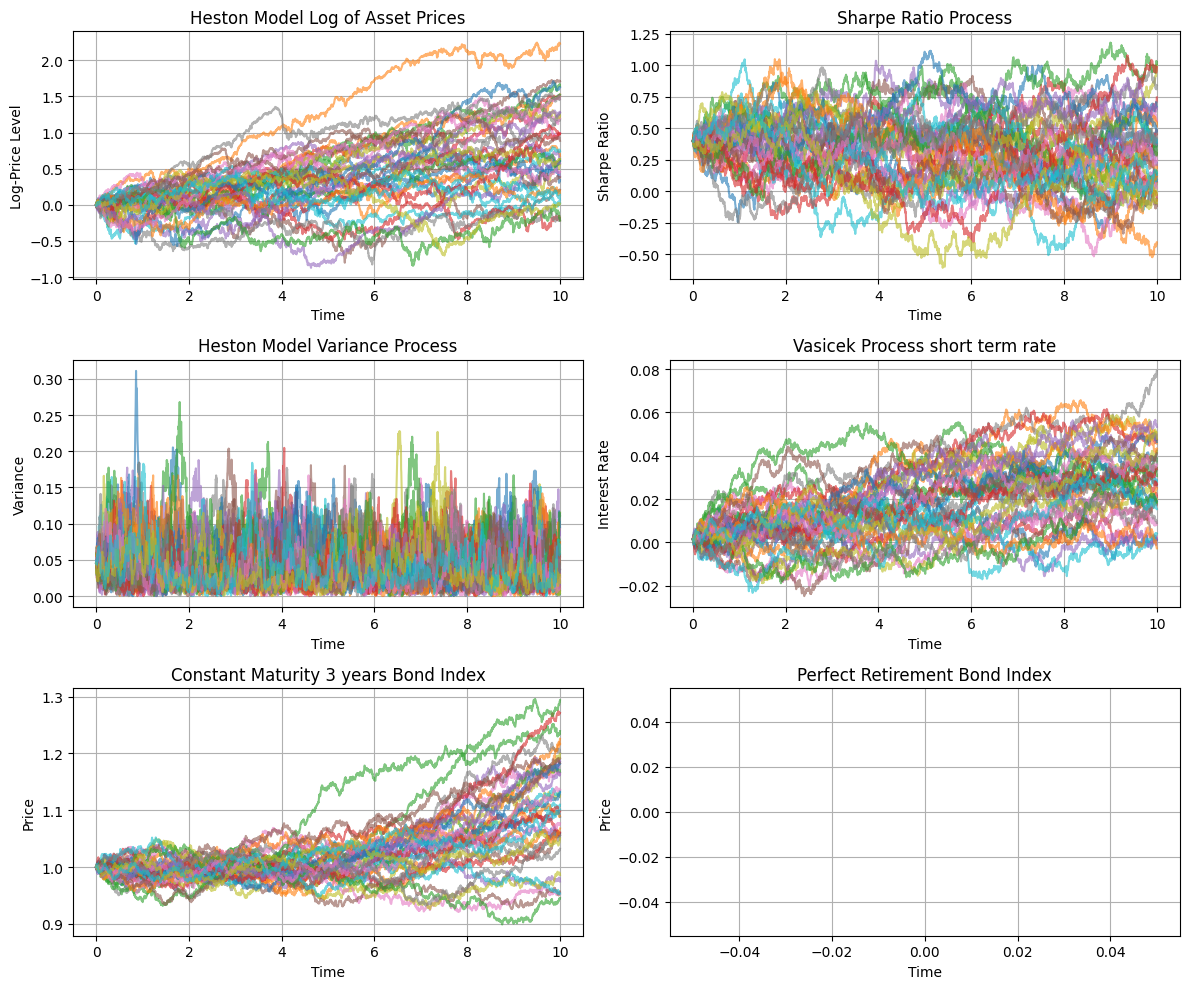

In [14]:
# Parameters
S0 = 1.0              # asset price
T = 10                  # time in years
N = 252*T              # number of time steps in simulation
M = 40                  # number of simulated paths
seed = 123              # simulation seed

simulated_market = MarketSimulator(T,N,M,seed, S0)
simulated_market.plot_market_simulation()

We can try to simulate 11 year bond, 12 year bonds, etc. to match our future essential cash flows. Then check the present value distribution that might be needed.

## Initialize client

In [15]:
class RetirementClient:
    def __init__(self,
                 name,
                 accumulation_years=10,
                 accumulation_cash_flow=0,
                 decumulation_years=20,
                 decumulation_cash_flow=50000,
                 periodicity = 12
                ):
        """
        Initializes a RetirementClient with given parameters.

        :param name: Name of the client
        :param accumulation_years: Number of years the client is saving money
        :param accumulation_cash_flow: Annual contribution during accumulation phase (per trading day)
        :param decumulation_years: Number of years the client is withdrawing money
        :param decumulation_cash_flow: Annual withdrawal amount during decumulation phase (only at start of each year)
        :param periodicity: Number of periods in a year
        """
        self.name = name
        self.accumulation_years = accumulation_years
        self.accumulation_cash_flow = accumulation_cash_flow
        self.decumulation_years = decumulation_years
        self.decumulation_cash_flow = decumulation_cash_flow
        self.periodicity = periodicity
        self.generate_cash_flows()
        
    def generate_cash_flows(self):
        """
        Generates a DataFrame of cash flows at a daily trading frequency (1/252 increments).
        
        - Accumulation period (X years, X*periodicity periods): Cash flow appears at period 1 of each year.
        - Decumulation period (Y years, Y*periodicity periodss): Cash flow appears at period 1 of each year.

        :return: pandas DataFrame with the following columns:
            - 'Period': The time index in trading days (1/252 increments)
            - 'Year': The corresponding year number
            - 'Pure_Cash_Flow': The nominal cash flows (without inflation adjustments)
        """
        total_periods = (self.accumulation_years + self.decumulation_years) * self.periodicity  # Total periods
        periods = np.arange(1, total_periods + 1)  # period index
        
        # Initialize cash flow array with zeros
        cash_flows = np.zeros(total_periods)
        
        # Set cash flow at the beginning of each year during decumulation
        for year in range(self.accumulation_years, self.accumulation_years + self.decumulation_years):
            cash_flows[year * self.periodicity] = self.decumulation_cash_flow
        
        # Convert to DataFrame
        self.cash_flows_df = pd.DataFrame({
            'Period': periods / self.periodicity, 
            'Year': (periods // self.periodicity) + 1,
            'Pure_Cash_Flow': cash_flows
            })
        self.cash_flows_df.index = self.cash_flows_df.Period

    def plot_cash_flows(self):
        """
        Plots the cash flow over the trading years.
        """
        plt.figure(figsize=(12, 5))
        plt.bar(self.cash_flows_df['Period'], self.cash_flows_df['Pure_Cash_Flow'], 
                color='darkblue', edgecolor='white', width=0.1)
        plt.xlabel("Time (Trading Years)")
        plt.ylabel("Cash Flow")
        plt.title(f"Cash Flow Projection for {self.name}")
        plt.axhline(0, color='black', linewidth=1)
        plt.show()

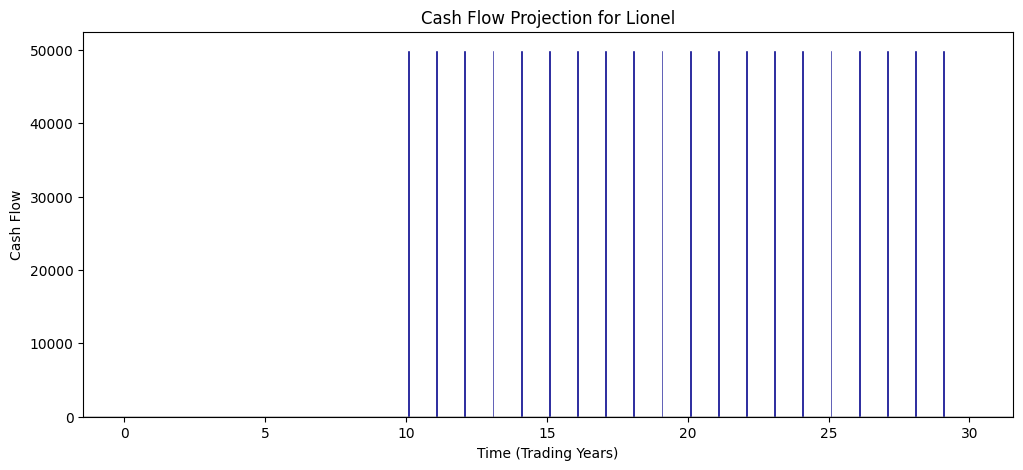

In [16]:
client = RetirementClient("Lionel",
                           accumulation_years=10,
                           accumulation_cash_flow=0,
                           decumulation_years=20,
                           decumulation_cash_flow=50000,
                           periodicity = 12)

client.plot_cash_flows()

## Retirement Bond

In [19]:
simulated_market.calculate_perfect_retirement_bond(client)

Simulating scenarios: 100%|█████████████████████| 40/40 [00:04<00:00,  8.83it/s]


Plot the market and the retirement bond index. If you would use M = 31, you would get full retirement bond price

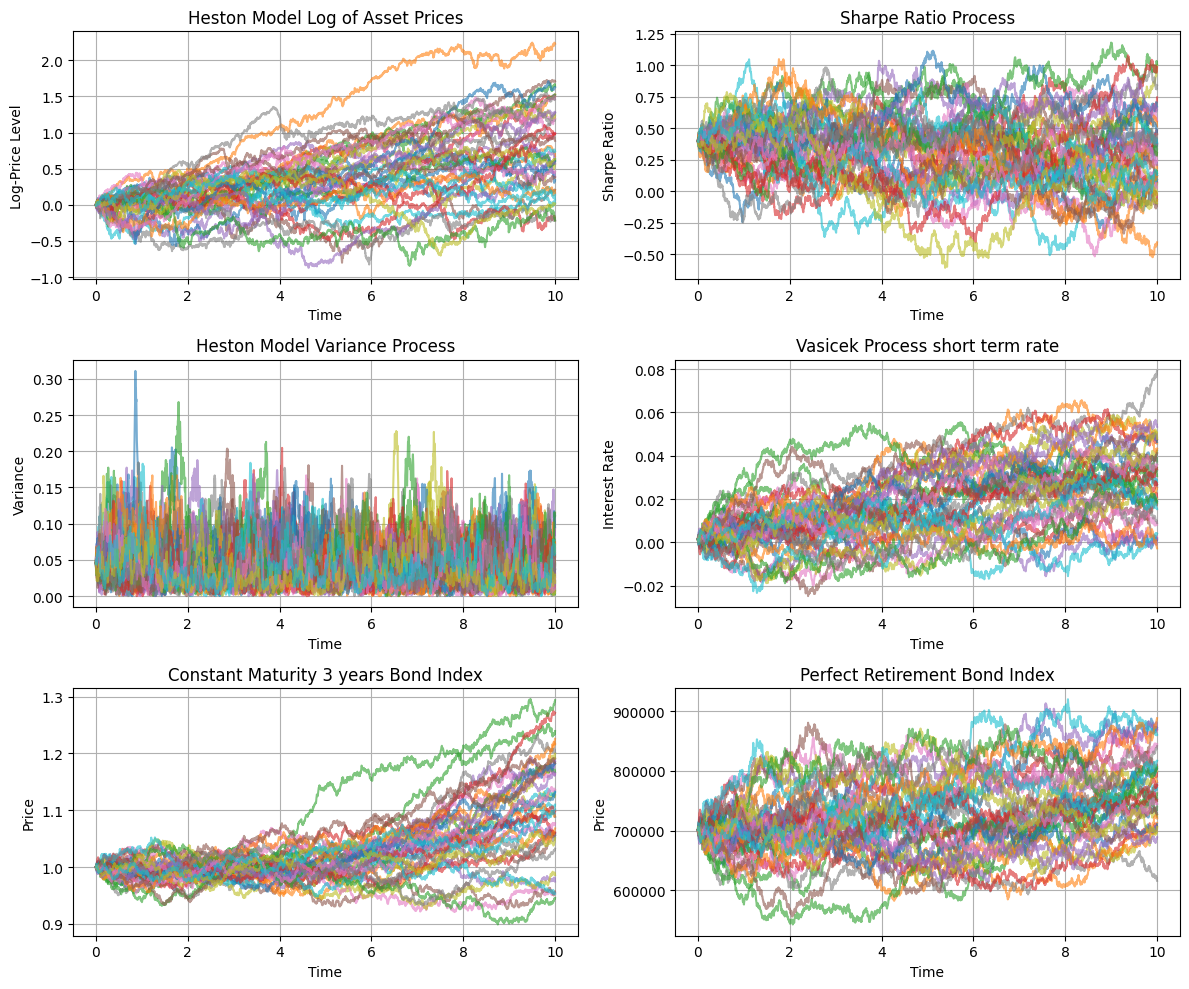

In [22]:
simulated_market.plot_market_simulation()

In [24]:
simulated_market.S_p.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.003968,1.010198,1.027608,0.992945,0.988860,0.968971,0.999769,1.006552,1.005764,1.010973,1.007557,...,1.001602,0.976535,1.004552,1.001435,0.993290,0.997814,0.989603,1.000400,1.023807,0.982998
0.007937,1.008726,1.009111,1.002069,0.992752,0.969305,0.986952,1.017002,1.008250,1.009773,1.013733,...,1.027868,0.995278,1.028635,1.007329,0.973231,0.995465,0.997028,0.986959,1.022976,0.985548
0.011905,1.020857,1.019384,1.004556,0.999705,0.956342,0.984693,1.035256,1.022141,1.028395,1.041006,...,1.020052,0.994432,1.012443,1.025306,0.970406,1.012328,0.978808,0.970939,1.014743,1.014782
0.015873,1.049815,1.002700,0.993708,1.017299,0.947774,0.978771,1.032117,1.035657,1.018968,1.037164,...,1.006693,0.963172,1.004511,1.016019,0.981626,1.007462,0.989439,0.978941,1.047706,1.003022


In [25]:
simulated_market.B_p.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0.000000,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,...,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006,1.000006
0.003968,0.998449,0.997450,1.001303,1.000954,0.996633,0.997695,1.000952,1.001295,1.001047,0.998922,...,1.000821,1.000389,1.000839,0.999483,0.997214,0.999776,1.000300,0.999756,1.002853,1.000788
0.007937,0.998718,0.998798,1.001690,1.000809,0.997542,0.995442,1.004846,1.000662,1.001208,0.999063,...,1.002605,1.001403,1.000380,1.000797,0.996555,1.001015,0.998254,0.999919,1.001834,1.001782
0.011905,1.000751,0.999422,1.000967,1.000873,0.996690,0.996104,1.004670,0.997999,1.002603,0.995894,...,1.003414,1.001150,1.000248,1.001742,0.994090,0.998764,0.998489,0.998950,1.000276,1.000597
0.015873,1.001099,0.996361,1.001810,1.001234,0.996708,0.995976,1.002574,0.998338,1.003189,0.995034,...,1.004588,1.000656,1.000144,1.003469,0.992482,0.997290,1.000237,0.995888,0.999325,1.003794


In [26]:
simulated_market.retirement_bond_p.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0.000000,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,...,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029,700763.613029
0.003968,697753.612544,695832.756662,703257.184144,702582.170118,694264.570592,696304.200216,702578.763219,703242.406658,702762.756724,698663.264448,...,702325.198504,701491.299194,702360.176268,699743.414004,695379.719405,700308.332553,701319.385996,700269.688947,706257.754881,702261.754674
0.007937,698255.215715,698404.452082,703998.544405,702294.373013,695988.299376,691966.458536,710119.324870,702010.447998,703064.314113,698920.185893,...,705767.670914,703440.746554,701465.861321,702266.039554,694095.127333,702688.689557,697367.715573,700572.397509,704280.467649,704174.697969
0.011905,702159.056706,699592.058282,702594.413932,702407.302529,694334.812144,693207.936877,709780.160891,696871.551233,705756.072518,692819.703997,...,707334.269196,702944.480538,701200.085717,704084.155276,689358.798776,698339.050722,697803.452163,698694.001819,701263.901078,701876.721163
0.015873,702820.497915,693695.452255,704215.108804,703096.185216,694346.714904,692938.347519,705714.091315,697504.072365,706890.335453,691150.925001,...,709612.907424,701981.615792,700989.099361,707424.653266,686263.632975,695490.722260,701154.426317,692799.111373,699420.119085,708059.390210


In [45]:
import pandas as pd
import numpy as np

class FundAllocationSimulator:
    def __init__(self, initial_savings, retirement_bond_p, r_p):
        """
        Initializes the FundAllocationSimulator class with initial savings, 
        retirement bond price data, and short-term interest rates.
        
        Parameters:
        - initial_savings (float): The initial amount invested by the individual.
        - retirement_bond_p (DataFrame): The retirement bond price data (simulated).
        - r_p (DataFrame): The short-term interest rates for the simulations.
        """
        self.initial_savings = initial_savings
        self.retirement_bond_p = retirement_bond_p
        self.r_p = r_p
        
        # Calculate the percentage change of the retirement bond price to get RL (Retirement Liability)
        self.RL = self.retirement_bond_p.pct_change().dropna()

        # Drop the first observation of r_p to match the alignment after pct_change
        self.r_p = self.r_p.drop(self.r_p.index[0])
        
        # Initialize an empty results DataFrame
        self.results_df = pd.DataFrame()

    def balanced_fund(PSP, GHP, x, rebalance_frequency=None):
        """
        Simulates investments in PSP and GHP with weight x in PSP and (1-x) in GHP.
        The portfolio will be rebalanced at the given frequency (if specified).
        
        Parameters:
        - PSP (DataFrame): The dataset containing the asset prices of the PSP over time.
        - GHP (DataFrame): The dataset containing the asset prices of the GHP over time.
        - x (float): The initial weight allocated to PSP, between 0 and 1.
        - rebalance_frequency (float or None): The frequency (in terms of time periods) at which to rebalance the portfolio.
          If None, rebalancing is never done.
        
        Returns:
        - portfolio_values (DataFrame): A time series of the portfolio's value over time.
        """
        
        # Step 1: Calculate returns for PSP and GHP using pct_change()
        # This computes the percentage change between the current and previous prices
        psp_returns = PSP.pct_change().dropna()  # Calculate the daily returns of PSP, remove NaN
        ghp_returns = GHP.pct_change().dropna()  # Calculate the daily returns of GHP, remove NaN
    
        # Step 2: Ensure that both PSP and GHP returns have the same length
        # In case the dataframes are not aligned, reindex one to match the other
        if len(psp_returns) != len(ghp_returns):
            common_index = psp_returns.index.intersection(ghp_returns.index)
            psp_returns = psp_returns.loc[common_index]
            ghp_returns = ghp_returns.loc[common_index]
        
        # Step 3: Simulate the portfolio
        # Initialize the portfolio value series, starting with an initial value of 1 (or any arbitrary starting value)
        portfolio_values = pd.Series(index=psp_returns.index)
        portfolio_values.iloc[0] = 1  # Starting value of portfolio
        
        # Step 4: Loop through each time period and compute the portfolio value
        # Invest x in PSP and (1 - x) in GHP
        for t in range(1, len(psp_returns)):
            # Calculate the current portfolio value based on previous value and asset returns
            portfolio_values.iloc[t] = portfolio_values.iloc[t-1] * (
                (1 + x * psp_returns.iloc[t]) + (1 + (1 - x) * ghp_returns.iloc[t]) - 1)
            
            # Step 5: Rebalance if the rebalance_frequency is specified
            if rebalance_frequency and t % int(rebalance_frequency) == 0:
                # Rebalance the portfolio: New weight is recalculated for PSP
                current_psp_value = portfolio_values.iloc[t] * x * (1 + psp_returns.iloc[t])
                current_ghp_value = portfolio_values.iloc[t] * (1 - x) * (1 + ghp_returns.iloc[t])
                total_value = current_psp_value + current_ghp_value
                x = current_psp_value / total_value  # Adjust weight to PSP for next period
            
        return portfolio_values

    def tracking_error(self, fund_returns):
        """
        Calculate the tracking error between the fund's returns and the retirement liability (RL).
        
        Parameters:
        - fund_returns (DataFrame): The returns of the balanced fund
        
        Returns:
        - tracking_error (float): The tracking error of the portfolio
        """
        return np.var(fund_returns - self.RL)

    def sharpe_ratio(self, fund_returns):
        """
        Calculate the Sharpe ratio of the portfolio.
        
        Parameters:
        - fund_returns (DataFrame): The returns of the balanced fund
        
        Returns:
        - sharpe_ratio (float): The Sharpe ratio of the portfolio
        """
        # Risk-free rate is assumed to be the short-term rates (r_p)
        return (np.mean(fund_returns) - np.mean(self.r_p)) / np.std(fund_returns)

    def run_simulation(self, PSP, GHP, x_values, rebalance_frequencies):
        """
        Runs multiple simulations for different x values and rebalance frequencies.
        
        Parameters:
        - PSP (DataFrame): The dataset containing the asset prices of the PSP over time.
        - GHP (DataFrame): The dataset containing the asset prices of the GHP over time.
        - x_values (array): A series of values representing the different weights to invest in PSP.
        - rebalance_frequencies (array): A series of rebalance frequencies to test (e.g., quarterly, annually).
        
        Returns:
        - self.results_df (DataFrame): A DataFrame containing results for each simulation scenario.
        """
        results = []

        for x in x_values:
            for rebalance_frequency in rebalance_frequencies:
                # Run the balanced fund simulation
                portfolio_values, _ = self.balanced_fund(PSP, GHP, x, rebalance_frequency)
                
                # Calculate annualized return
                total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
                annualized_return = (1 + total_return) ** (1 / (len(portfolio_values) / 252)) - 1  # Assuming 252 trading days
                
                # Calculate variance of fund return (annualized)
                fund_returns = portfolio_values.pct_change().dropna()
                annualized_variance = np.var(fund_returns) * 252  # Annualized variance
                
                # Calculate Sharpe ratio
                sharpe_ratio = self.sharpe_ratio(fund_returns)
                
                # Calculate tracking error
                tracking_err = self.tracking_error(fund_returns)
                
                # Store the results for this scenario
                results.append([x, rebalance_frequency, annualized_variance, annualized_return, sharpe_ratio, tracking_err])
        
        # Create a DataFrame to hold all results
        self.results_



In [46]:
fund_allocation_simulator = FundAllocationSimulator(initial_savings = 287000,
                                                    retirement_bond_p = simulated_market.retirement_bond_p,
                                                    r_p = simulated_market.r_p)

In [47]:
returns_of_fund, weights_of_assets = fund_allocation_simulator.balanced_fund(PSP = simulated_market.S_p,
                                                                           GHP = simulated_market.B_p, 
                                                                           x = 0.5, 
                                                                           rebalance_frequency=None)

TypeError: balanced_fund() got multiple values for argument 'PSP'

In [48]:
weights_of_assets

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0.003968,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
0.007937,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
0.011905,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
0.015873,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
0.019841,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.984127,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9.988095,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9.992063,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9.996032,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
